# Training on A100 with checkpoints


In [1]:
import os
import re
import math
import seaborn as sns
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import platform

# 根据操作系统设置中文字体
system = platform.system()

if system == "Darwin":  # macOS
    plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti SC', 'STHeiti', 'Arial Unicode MS']
elif system == "Linux":
    plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'WenQuanYi Micro Hei', 'Noto Sans CJK SC']
elif system == "Windows":
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'KaiTi', 'FangSong']
else:
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

print(f"已设置{system}系统的中文字体支持")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler

已设置Linux系统的中文字体支持


In [2]:
# ========== 初始化自定义 Dataset ==========
class GWDataset(Dataset):
    def __init__(self, folder_path, snr_list=None, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.snr_list = snr_list or ["50.00", "100.00", "200.00"]
        
        # 检查文件夹是否存在
        if not os.path.isdir(folder_path):
            raise FileNotFoundError(f"数据目录不存在: {folder_path}")
            
        self.file_index = []
        snr_pattern = re.compile(r"_SNR(\d+\.\d+)\.h5")

        # 使用更安全的方式遍历文件
        for fname in os.listdir(folder_path):
            if not fname.endswith(".h5"):
                continue
                
            full_path = os.path.join(folder_path, fname)
            
            # 跳过非文件项（如目录）
            if not os.path.isfile(full_path):
                print(f"跳过非文件项: {full_path}")
                continue
                
            # 检查文件可读性
            if not os.access(full_path, os.R_OK):
                print(f"警告: 文件不可读，跳过: {full_path}")
                continue
                
            match = snr_pattern.search(fname)
            if match:
                snr = match.group(1)
                if snr in self.snr_list:
                    # 尝试打开文件以验证完整性
                    try:
                        with h5py.File(full_path, "r") as f:
                            # 简单验证文件结构
                            if "Data" not in f:
                                print(f"警告: 文件缺少'Data'组，跳过: {full_path}")
                                continue
                                
                            # 检查必要属性
                            data_group = f["Data"]
                            required_attrs = ["mc_true", "phis_true", "thetas_true"]
                            if not all(attr in data_group.attrs for attr in required_attrs):
                                print(f"警告: 文件缺少必要属性，跳过: {full_path}")
                                continue
                                
                        # 文件验证通过，添加到索引
                        self.file_index.append((full_path, snr))
                        
                    except (OSError, IOError) as e:
                        print(f"文件打开错误 {full_path}: {str(e)}，跳过")
                    except Exception as e:
                        print(f"处理文件时出错 {full_path}: {str(e)}，跳过")

        if not self.file_index:
            raise ValueError("没有匹配到任何指定 SNR 的文件，请检查路径或 snr_list 设置")
        else:
            print(f"成功加载 {len(self.file_index)} 个文件")

    def __len__(self):
        return len(self.file_index)

    def __getitem__(self, idx):
        file_path, snr = self.file_index[idx]
        
        try:
            with h5py.File(file_path, "r") as f:
                data_group = f["Data"]
                
                # 处理不同的数据结构
                if isinstance(data_group, h5py.Group):
                    white_data = torch.tensor(data_group["white_Data"][:], dtype=torch.float32)
                    white_signal = torch.tensor(data_group["white_signal"][:], dtype=torch.float32)
                elif isinstance(data_group, h5py.Dataset):
                    # 处理旧格式的数据集
                    white_data = torch.tensor(data_group[0].flatten(), dtype=torch.float32)
                    white_signal = torch.tensor(data_group[1].flatten(), dtype=torch.float32)
                else:
                    raise ValueError(f"未知的数据结构: {file_path}")
                
                attrs = {k: data_group.attrs[k] for k in data_group.attrs}
                
        except (OSError, IOError) as e:
            # 文件读取错误时返回空数据并记录警告
            print(f"读取文件错误 {file_path}: {str(e)}")
            seq_len = 6184  # 默认序列长度
            white_data = torch.zeros(seq_len, dtype=torch.float32)
            white_signal = torch.zeros(seq_len, dtype=torch.float32)
            attrs = {
                "mc_true": 0.0,
                "phis_true": 0.0,
                "thetas_true": 0.0
            }
        except Exception as e:
            print(f"处理文件时发生意外错误 {file_path}: {str(e)}")
            raise e

        sample = {
            "white_data": white_data,
            "white_signal": white_signal,
            "attributes": attrs,
            "mc_true": attrs.get("mc_true", 0.0),
            "phis_true": attrs.get("phis_true", 0.0),
            "thetas_true": attrs.get("thetas_true", 0.0),
            "snr": snr,
            "filename": os.path.basename(file_path)
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [3]:
# 构建掩码 1表示弱信号，0表示强信号，2表示第二段弱信号
def generate_mask(data: torch.Tensor, threshold_factor=5.0):
    B, L = data.shape
    mask = torch.ones_like(data, dtype=torch.long)  # 初始为全1（弱信号）
    stds = torch.std(data, dim=1, keepdim=True)  # (B, 1)
    thresholds = threshold_factor * stds         # 每条数据的阈值 (B, 1)

    abs_data = data.abs()  # (B, L)
    for i in range(B):
        above_th = (abs_data[i] > thresholds[i])  # bool mask
        strong_indices = torch.nonzero(above_th).squeeze()

        if strong_indices.numel() > 0:
            # 处理0维张量的情况（只有一个强信号点）
            if strong_indices.dim() == 0:
                start = end = strong_indices.item()
            else:
                start = strong_indices[0].item()
                end = strong_indices[-1].item()
            
            mask[i, start:end+1] = 0  # 强信号（包含end点）
            mask[i, end+1:] = 2       # 第二段弱信号

    return mask

In [4]:
# 标准化
def standardize_batch(data: torch.Tensor, signal: torch.Tensor, mask: torch.Tensor, amplification=1.0):
    # 放大弱信号部分
    signal_amplified = signal.clone()
    signal_amplified[mask == 1] *= amplification

    # 提取弱信号索引
    weak_indices = (mask == 1)

    # RobustScaler 模拟：中位数与 IQR（近似标准化）
    weak_values = data[weak_indices].view(-1)
    median = weak_values.median()
    q1 = weak_values.kthvalue(int(len(weak_values) * 0.25))[0]
    q3 = weak_values.kthvalue(int(len(weak_values) * 0.75))[0]
    iqr = q3 - q1 + 1e-8  # 避免除零

    # 标准化公式：(x - median) / IQR
    data_std = (data - median) / iqr
    signal_std = (signal_amplified - median) / iqr

    stats = {"median": median.item(), "iqr": iqr.item()}
    return data_std, signal_std, stats

In [5]:
# 数据集划分（训练/验证/测试）
def split_dataset(dataset, train_ratio=0.2, val_ratio=0.2):
    total_len = len(dataset)
    train_len = int(total_len * train_ratio)
    val_len = int(total_len * val_ratio)
    test_len = total_len - train_len - val_len
    return random_split(dataset, [train_len, val_len, test_len])

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=7, stride=stride, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.LeakyReLU = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion * out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.LeakyReLU(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.LeakyReLU(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.LeakyReLU = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, 1)  # 输出一个值

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.LeakyReLU(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out


def ResNetModel():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [7]:
class WaveUNetWithTransformer(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder（使用大卷积核，并增加层数）
        self.encoder1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=15, padding=7), nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=15, padding=7), nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=15, padding=7), nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.encoder4 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=15, padding=7), nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Transformer bottleneck
        self.transformer_input_proj = nn.Conv1d(128, 256, kernel_size=1)
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=512, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.transformer_output_proj = nn.Conv1d(256, 128, kernel_size=1)

        # Decoder（镜像结构）
        self.decoder1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="linear", align_corners=True),
            nn.Conv1d(128, 64, kernel_size=15, padding=7), nn.ReLU()
        )
        self.decoder2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="linear", align_corners=True),
            nn.Conv1d(64, 32, kernel_size=15, padding=7), nn.ReLU()
        )
        self.decoder3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="linear", align_corners=True),
            nn.Conv1d(32, 16, kernel_size=15, padding=7), nn.ReLU()
        )
        self.decoder4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="linear", align_corners=True),
            nn.Conv1d(16, 1, kernel_size=15, padding=7)
        )

    def forward(self, x, mask):
        input_len = x.shape[-1]
        residual = x  # 用于强信号跳跃连接

        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)

        x_trans = self.transformer_input_proj(x4).permute(0, 2, 1)
        x_trans = self.transformer(x_trans)
        x_trans = self.transformer_output_proj(x_trans.permute(0, 2, 1))

        x = self.decoder1(x_trans)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)

        # 输出与输入对齐
        if x.shape[-1] > input_len:
            x = x[:, :, :input_len]
        elif x.shape[-1] < input_len:
            x = F.pad(x, (0, input_len - x.shape[-1]))
        
        # 输出处理：根据掩码合成最终输出
        # output = x * (mask == 1) + residual * (mask == 0)  # 弱信号①+强信号
        # output = output * (mask != 2)  # 再将弱信号②置 0
        output = (x * (mask == 1).float() + residual * (mask == 0).float()) * (mask != 2).float()
        
        return output

In [8]:
# 掩码损失函数
def masked_loss(output, target, mask, lambda_mse=5.0, lambda_smooth=1.0, stability_penalty=1.0):
    # ========== 主损失项 (MSE) ==========
    loss = F.mse_loss(output, target, reduction='none')  # (B, 1, T)
    active = (mask == 1).float()
    core = (loss * active).sum() / (active.sum() + 1e-8)
    # ========== 平滑项（仅对弱信号①） ==========
    diff = output[:, :, 1:] - output[:, :, :-1]
    mask_diff = (mask[:, :, 1:] == 1) & (mask[:, :, :-1] == 1)  # 相邻都是弱信号①
    smooth_penalty = (diff**2 * mask_diff.float()).sum() / (mask_diff.float().sum() + 1e-8)
    # ========== 标准差惩罚项（防塌缩，仅对弱信号①） ==========
    weak_output = output[mask == 1]
    std_penalty = 1.0 / (torch.std(weak_output) + 1e-4)  # 防止输出塌缩为常数
    # ========== 总损失 ==========
    total_loss = lambda_mse * core + lambda_smooth * smooth_penalty + stability_penalty * std_penalty
    return total_loss

In [9]:
# 测试
def test_model_and_save_labels_batched(model, test_loader, device, output_dir="pt_chunks", base_name="denoised_batch", target_names=["mc_true", "phis_true", "thetas_true"]):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    batch_count = 0

    with torch.no_grad():
        for batch in test_loader:
            white_data = batch["white_data"].to(device)
            mask = generate_mask(white_data).unsqueeze(1).to(device)
            x = white_data.unsqueeze(1)

            # 标准化处理
            x_std, _, _ = standardize_batch(x.squeeze(1), x.squeeze(1), mask.squeeze(1))
            x_std = x_std.unsqueeze(1).to(device)

            # 去噪输出
            output = model(x_std, mask).cpu()

            # 提取三类标签并组合为 (B, 3)
            mc = torch.tensor(batch["mc_true"], dtype=torch.float32).view(-1, 1)
            phis = torch.tensor(batch["phis_true"], dtype=torch.float32).view(-1, 1)
            thetas = torch.tensor(batch["thetas_true"], dtype=torch.float32).view(-1, 1)
            targets = torch.cat([mc, phis, thetas], dim=1)

            # 保存文件
            file_path = os.path.join(output_dir, f"{base_name}_{batch_count:04d}.pt")
            torch.save({
                "denoised": output,
                "targets": targets,
                "target_names": target_names
            }, file_path)
            
            torch.cuda.empty_cache()  # 保存后立即释放缓存

            print(f"[Saved] {file_path} ← {output.shape[0]} samples")
            batch_count += 1

    print(f"[Done] 共保存 {batch_count} 个批次文件于: {output_dir}")

In [ ]:
def selective_inverse_transform(signal, mask, stats, amplification=10.0):
    signal = signal.copy()
    signal = signal * stats["iqr"] + stats["median"]  # 所有区域反标准化
    signal[mask == 1] /= amplification                # 仅弱信号再除以放大倍数
    return signal

# 可视化去噪效果（输入、预测、纯信号）
def visualize_denoising_subplots(model, test_loader, device, sample_index=0, save_plots=True, save_dir="denoising_plots"):
    """
    可视化去噪效果并保存图表
    Args:
        model: 去噪模型
        test_loader: 测试数据加载器
        device: 设备
        sample_index: 要可视化的样本索引
        save_plots: 是否保存图表
        save_dir: 保存目录
    """
    # 创建保存目录
    if save_plots:
        os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    with torch.no_grad():
        batch = next(iter(test_loader))
        white_data = batch["white_data"].to(device)
        white_signal = batch["white_signal"].to(device)
        mask = generate_mask(white_data).unsqueeze(1).to(device)
        print(mask[sample_index])

        x = white_data.unsqueeze(1)
        y = white_signal.unsqueeze(1)

        # 标准化 + 获取统计量
        x_std, y_std, stats = standardize_batch(x.squeeze(1), y.squeeze(1), mask.squeeze(1))
        x_std = x_std.unsqueeze(1).to(device)
        y_std = y_std.unsqueeze(1).to(device)

        output = model(x_std, mask).squeeze(1).cpu().numpy()
        print(output[sample_index])

    # 选择样本
    input_signal = x[sample_index].squeeze().cpu().numpy()
    denoised_signal = output[sample_index]
    clean_signal = y[sample_index].squeeze().cpu().numpy()
    signal_mask = mask[sample_index].squeeze().cpu().numpy()

    # 反归一化
    input_signal = selective_inverse_transform(input_signal, signal_mask, stats, amplification=1.0)
    denoised_signal = selective_inverse_transform(denoised_signal, signal_mask, stats, amplification=1.0)
    clean_signal = selective_inverse_transform(clean_signal, signal_mask, stats, amplification=1.0)

    # 绘图
    fig, axs = plt.subplots(3, 1, figsize=(15, 9), sharex=True)
    axs[0].plot(input_signal, color='orange')
    axs[0].set_title("Noisy Input", fontsize=14)
    axs[1].plot(denoised_signal, color='green')
    axs[1].set_title("Denoised Output", fontsize=14)
    axs[2].plot(clean_signal, color='blue')
    axs[2].set_title("Ground Truth Signal", fontsize=14)

    for ax in axs:
        # ax.set_ylim(-1, 1)
        ax.grid(True)
    
    plt.tight_layout()
    
    # 保存图表
    if save_plots:
        save_path = os.path.join(save_dir, f"denoising_comparison_sample_{sample_index}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 去噪对比图已保存: {save_path}")
    
    plt.show()

In [11]:
## 完整的模型保存和加载系统

import json
import os
from datetime import datetime

class ModelCheckpoint:
    """完整的模型检查点保存和加载系统"""
    
    def __init__(self, save_dir="checkpoints"):
        """
        初始化模型检查点管理器
        Args:
            save_dir: 保存检查点的目录
        """
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
    
    def save_checkpoint(self, model, optimizer, scheduler, epoch, train_loss, val_loss, 
                       best_val_loss, model_config=None, training_config=None, 
                       checkpoint_name=None):
        """
        保存完整的模型检查点
        Args:
            model: 模型实例
            optimizer: 优化器
            scheduler: 学习率调度器
            epoch: 当前轮次
            train_loss: 训练损失
            val_loss: 验证损失
            best_val_loss: 最佳验证损失
            model_config: 模型配置字典
            training_config: 训练配置字典
            checkpoint_name: 检查点名称，如果为None则自动生成
        """
        if checkpoint_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            checkpoint_name = f"checkpoint_epoch_{epoch}_{timestamp}.pt"
        
        checkpoint_path = os.path.join(self.save_dir, checkpoint_name)
        
        # 准备保存的数据
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'best_val_loss': best_val_loss,
            'timestamp': datetime.now().isoformat(),
            'model_config': model_config or {},
            'training_config': training_config or {}
        }
        
        # 保存检查点
        torch.save(checkpoint, checkpoint_path)
        
        # 保存元数据到JSON文件（便于查看）
        metadata = {
            'checkpoint_name': checkpoint_name,
            'epoch': epoch,
            'train_loss': float(train_loss),
            'val_loss': float(val_loss),
            'best_val_loss': float(best_val_loss),
            'timestamp': checkpoint['timestamp'],
            'model_config': model_config or {},
            'training_config': training_config or {}
        }
        
        metadata_path = os.path.join(self.save_dir, checkpoint_name.replace('.pt', '_metadata.json'))
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)
        
        print(f"✅ 检查点已保存: {checkpoint_path}")
        return checkpoint_path
    
    def load_checkpoint(self, checkpoint_path, model, optimizer=None, scheduler=None, device='cpu'):
        """
        加载模型检查点
        Args:
            checkpoint_path: 检查点文件路径
            model: 模型实例
            optimizer: 优化器（可选）
            scheduler: 学习率调度器（可选）
            device: 设备
        Returns:
            dict: 包含加载信息的字典
        """
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"检查点文件不存在: {checkpoint_path}")
        
        print(f"📂 正在加载检查点: {checkpoint_path}")
        
        # 加载检查点
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        
        # 加载模型状态
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # 加载优化器状态（如果提供）
        if optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print("✅ 优化器状态已加载")
        
        # 加载调度器状态（如果提供）
        if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            print("✅ 学习率调度器状态已加载")
        
        # 提取训练信息
        loaded_info = {
            'epoch': checkpoint.get('epoch', 0),
            'train_loss': checkpoint.get('train_loss', float('inf')),
            'val_loss': checkpoint.get('val_loss', float('inf')),
            'best_val_loss': checkpoint.get('best_val_loss', float('inf')),
            'timestamp': checkpoint.get('timestamp', 'unknown'),
            'model_config': checkpoint.get('model_config', {}),
            'training_config': checkpoint.get('training_config', {})
        }
        
        print(f"✅ 检查点加载完成!")
        print(f"   - 轮次: {loaded_info['epoch']}")
        print(f"   - 验证损失: {loaded_info['val_loss']:.6f}")
        print(f"   - 最佳验证损失: {loaded_info['best_val_loss']:.6f}")
        print(f"   - 保存时间: {loaded_info['timestamp']}")
        
        return loaded_info
    
    def save_best_model(self, model, val_loss, model_name="best_model.pt"):
        """
        保存最佳模型（只保存模型权重）
        Args:
            model: 模型实例
            val_loss: 验证损失
            model_name: 模型文件名
        """
        model_path = os.path.join(self.save_dir, model_name)
        torch.save({
            'model_state_dict': model.state_dict(),
            'val_loss': val_loss,
            'timestamp': datetime.now().isoformat()
        }, model_path)
        print(f"🏆 最佳模型已保存: {model_path} (验证损失: {val_loss:.6f})")
        return model_path
    
    def load_best_model(self, model, model_name="best_model.pt", device='cpu'):
        """
        加载最佳模型
        Args:
            model: 模型实例
            model_name: 模型文件名
            device: 设备
        """
        model_path = os.path.join(self.save_dir, model_name)
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"最佳模型文件不存在: {model_path}")
        
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"🏆 最佳模型已加载: {model_path}")
        if 'val_loss' in checkpoint:
            print(f"   - 验证损失: {checkpoint['val_loss']:.6f}")
        if 'timestamp' in checkpoint:
            print(f"   - 保存时间: {checkpoint['timestamp']}")
    
    def list_checkpoints(self):
        """列出所有可用的检查点"""
        checkpoints = []
        for file in os.listdir(self.save_dir):
            if file.endswith('.pt') and not file.startswith('best_'):
                metadata_file = file.replace('.pt', '_metadata.json')
                metadata_path = os.path.join(self.save_dir, metadata_file)
                
                if os.path.exists(metadata_path):
                    with open(metadata_path, 'r', encoding='utf-8') as f:
                        metadata = json.load(f)
                    checkpoints.append(metadata)
                else:
                    # 如果没有元数据文件，只显示文件名
                    checkpoints.append({'checkpoint_name': file, 'epoch': 'unknown'})
        
        # 按轮次排序
        checkpoints.sort(key=lambda x: x.get('epoch', 0))
        return checkpoints
    
    def cleanup_old_checkpoints(self, keep_last_n=5):
        """
        清理旧的检查点，只保留最近的N个
        Args:
            keep_last_n: 保留的检查点数量
        """
        checkpoints = self.list_checkpoints()
        if len(checkpoints) <= keep_last_n:
            print(f"当前检查点数量({len(checkpoints)})未超过保留数量({keep_last_n})，无需清理")
            return
        
        # 删除旧的检查点
        to_remove = checkpoints[:-keep_last_n]
        for checkpoint in to_remove:
            checkpoint_name = checkpoint['checkpoint_name']
            checkpoint_path = os.path.join(self.save_dir, checkpoint_name)
            metadata_path = checkpoint_path.replace('.pt', '_metadata.json')
            
            # 删除检查点文件
            if os.path.exists(checkpoint_path):
                os.remove(checkpoint_path)
                print(f"🗑️ 已删除旧检查点: {checkpoint_name}")
            
            # 删除元数据文件
            if os.path.exists(metadata_path):
                os.remove(metadata_path)
        
        print(f"✅ 清理完成，保留了最近的 {keep_last_n} 个检查点")

# 创建检查点管理器实例
checkpoint_manager = ModelCheckpoint(save_dir="model_checkpoints")
print("✅ 模型检查点管理器已初始化")


✅ 模型检查点管理器已初始化


In [12]:
# 改进的训练函数，支持从检查点继续训练
def train_model_with_checkpoints(model, train_loader, val_loader, optimizer, device, 
                                num_epochs=120, checkpoint_manager=None, 
                                resume_from_checkpoint=None, save_every_n_epochs=10,
                                model_config=None, training_config=None):
    """
    带检查点支持的训练函数
    Args:
        model: 模型实例
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        optimizer: 优化器
        device: 设备
        num_epochs: 总训练轮次
        checkpoint_manager: 检查点管理器
        resume_from_checkpoint: 要恢复的检查点路径
        save_every_n_epochs: 每隔多少轮次保存一次检查点
        model_config: 模型配置
        training_config: 训练配置
    """
    
    # 初始化变量
    start_epoch = 0
    best_val_loss = float('inf')
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    
    # 如果需要从检查点恢复
    if resume_from_checkpoint and checkpoint_manager:
        try:
            loaded_info = checkpoint_manager.load_checkpoint(
                resume_from_checkpoint, model, optimizer, scheduler, device
            )
            start_epoch = loaded_info['epoch']
            best_val_loss = loaded_info['best_val_loss']
            print(f"🔄 从轮次 {start_epoch} 继续训练，当前最佳验证损失: {best_val_loss:.6f}")
        except Exception as e:
            print(f"❌ 加载检查点失败: {e}")
            print("🆕 从头开始训练")
            start_epoch = 0
            best_val_loss = float('inf')
    
    # 准备训练和模型配置信息
    if training_config is None:
        training_config = {
            'num_epochs': num_epochs,
            'learning_rate': optimizer.param_groups[0]['lr'],
            'optimizer': type(optimizer).__name__,
            'scheduler': type(scheduler).__name__,
            'device': str(device),
            'batch_size': train_loader.batch_size,
            'train_dataset_size': len(train_loader.dataset),
            'val_dataset_size': len(val_loader.dataset)
        }
    
    if model_config is None:
        model_config = {
            'model_type': type(model).__name__,
            'total_params': sum(p.numel() for p in model.parameters()),
            'trainable_params': sum(p.numel() for p in model.parameters() if p.requires_grad)
        }
    
    print(f"🚀 开始训练:")
    print(f"   - 模型: {model_config['model_type']}")
    print(f"   - 总参数量: {model_config['total_params']:,}")
    print(f"   - 可训练参数: {model_config['trainable_params']:,}")
    print(f"   - 设备: {device}")
    print(f"   - 训练轮次: {start_epoch} -> {num_epochs}")
    print(f"   - 学习率: {training_config['learning_rate']}")
    
    for epoch in range(start_epoch, num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        for batch in train_loader:
            white_data = batch["white_data"].to(device)
            white_signal = batch["white_signal"].to(device)

            mask = generate_mask(white_data).unsqueeze(1).to(device)

            x = white_data.unsqueeze(1)
            y = white_signal.unsqueeze(1)

            x_std, y_std, _ = standardize_batch(x.squeeze(1), y.squeeze(1), mask.squeeze(1))
            x_std = x_std.unsqueeze(1).to(device)
            y_std = y_std.unsqueeze(1).to(device)

            optimizer.zero_grad()
            output = model(x_std, mask)
            loss = masked_loss(output, y_std, mask)
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1
        
        train_loss /= train_batches

        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                white_data = batch["white_data"].to(device)
                white_signal = batch["white_signal"].to(device)

                mask = generate_mask(white_data).unsqueeze(1).to(device)

                x = white_data.unsqueeze(1)
                y = white_signal.unsqueeze(1)

                x_std, y_std, _ = standardize_batch(x.squeeze(1), y.squeeze(1), mask.squeeze(1))
                x_std = x_std.unsqueeze(1).to(device)
                y_std = y_std.unsqueeze(1).to(device)

                output = model(x_std, mask)
                loss = masked_loss(output, y_std, mask)
                val_loss += loss.item()
                val_batches += 1
        
        val_loss /= val_batches

        # 学习率调度
        scheduler.step(val_loss)

        # 输出训练信息
        current_lr = optimizer.param_groups[0]['lr']
        output_std = output.std().item() if 'output' in locals() else 0.0
        
        print(f"{epoch+1:3d}/{num_epochs}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}, "
              f"Output Std = {output_std:.4f}, LR = {current_lr:.2e}")

        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if checkpoint_manager:
                checkpoint_manager.save_best_model(model, val_loss, "best_denoising_model.pt")
            else:
                torch.save(model.state_dict(), "best_denoising_model.pt")
            print("  🏆 Best model saved!")

        # 定期保存检查点
        if checkpoint_manager and (epoch + 1) % save_every_n_epochs == 0:
            checkpoint_manager.save_checkpoint(
                model, optimizer, scheduler, epoch + 1, train_loss, val_loss, 
                best_val_loss, model_config, training_config
            )
        
        # 每50轮清理一次旧检查点
        if checkpoint_manager and (epoch + 1) % 50 == 0:
            checkpoint_manager.cleanup_old_checkpoints(keep_last_n=5)
    
    # 训练结束后保存最终检查点
    if checkpoint_manager:
        final_checkpoint = checkpoint_manager.save_checkpoint(
            model, optimizer, scheduler, num_epochs, train_loss, val_loss, 
            best_val_loss, model_config, training_config, 
            checkpoint_name=f"final_checkpoint_epoch_{num_epochs}.pt"
        )
        print(f"🎯 训练完成! 最终检查点: {final_checkpoint}")
    
    print(f"✅ 训练完成! 最佳验证损失: {best_val_loss:.6f}")
    return best_val_loss


In [13]:
# 实用工具函数
def list_available_checkpoints(checkpoint_manager):
    """列出所有可用的检查点"""
    print("📋 可用的检查点:")
    print("-" * 80)
    
    checkpoints = checkpoint_manager.list_checkpoints()
    if not checkpoints:
        print("   暂无检查点")
        return
    
    for i, checkpoint in enumerate(checkpoints):
        print(f"{i+1:2d}. {checkpoint['checkpoint_name']}")
        print(f"     轮次: {checkpoint.get('epoch', 'unknown')}")
        print(f"     验证损失: {checkpoint.get('val_loss', 'unknown')}")
        print(f"     保存时间: {checkpoint.get('timestamp', 'unknown')}")
        print()

def create_new_training_session(data_folder, target_snr=["200.00"], model_type="WaveUNet"):
    """创建新的训练会话"""
    print("🆕 创建新的训练会话...")
    
    # 重新加载数据集
    dataset = GWDataset(data_folder, snr_list=target_snr)
    print(f"📊 数据集加载完成: {len(dataset)} 个样本")
    
    # 数据集划分
    train_set, val_set, test_set = split_dataset(dataset)
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=24, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=24, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=24, pin_memory=True)
    
    # 创建模型
    if model_type == "WaveUNet":
        model = WaveUNetWithTransformer()
    elif model_type == "ResNet":
        model = ResNetModel()
    else:
        raise ValueError(f"不支持的模型类型: {model_type}")
    
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
    
    return model, optimizer, train_loader, val_loader, test_loader

def continue_training_from_checkpoint(checkpoint_path, data_folder=None, target_snr=None):
    """从检查点继续训练"""
    print("🔄 从检查点继续训练...")
    
    # 如果提供了新的数据，重新加载数据集
    if data_folder and target_snr:
        print("📊 使用新的训练数据...")
        model, optimizer, train_loader, val_loader, test_loader = create_new_training_session(
            data_folder, target_snr
        )
    else:
        print("📊 使用原有的训练数据...")
        # 这里应该使用之前的数据加载器，如果没有则需要重新创建
        # 为了演示，我们重新创建
        model, optimizer, train_loader, val_loader, test_loader = create_new_training_session(
            "/home/ud202180035/DNN_for_GW_Parameter_Space_Estimation/waveforms2", ["200.00"]
        )
    
    return model, optimizer, train_loader, val_loader, test_loader


In [14]:
## 使用示例和说明

"""
使用指南：模型保存和加载系统

1. 从头开始训练：
   - 创建新的训练会话
   - 使用 train_model_with_checkpoints 进行训练
   - 系统会自动保存最佳模型和定期检查点

2. 从检查点继续训练：
   - 查看可用检查点
   - 选择要继续的检查点
   - 可以使用相同数据或更换新数据继续训练

3. 使用不同数据继续训练：
   - 加载预训练模型
   - 更换训练数据集
   - 继续训练以适应新数据
"""

# ============================================================================
# 示例 1: 从头开始训练
# ============================================================================
def example_train_from_scratch():
    """示例：从头开始训练"""
    print("=" * 60)
    print("示例 1: 从头开始训练")
    print("=" * 60)
    
    # 创建新的训练会话
    model, optimizer, train_loader, val_loader, test_loader = create_new_training_session(
        data_folder="/home/ud202180035/DNN_for_GW_Parameter_Space_Estimation/waveforms2",
        target_snr=["200.00"],
        model_type="WaveUNet"
    )
    
    # 开始训练（带检查点支持）
    best_loss = train_model_with_checkpoints(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=200,  # 可根据需要调整
        checkpoint_manager=checkpoint_manager,
        save_every_n_epochs=10  # 每10轮保存一次检查点
    )
    
    return model, best_loss

# ============================================================================
# 示例 2: 从检查点继续训练（相同数据）
# ============================================================================
def example_continue_from_checkpoint():
    """示例：从检查点继续训练"""
    print("=" * 60)
    print("示例 2: 从检查点继续训练")
    print("=" * 60)
    
    # 查看可用检查点
    list_available_checkpoints(checkpoint_manager)
    
    # 选择一个检查点（这里使用示例路径，实际使用时需要替换）
    checkpoint_path = "model_checkpoints/checkpoint_epoch_50_20231201_123456.pt"  # 示例路径
    
    # 如果检查点存在，从该点继续训练
    if os.path.exists(checkpoint_path):
        # 创建模型和数据加载器
        model, optimizer, train_loader, val_loader, test_loader = continue_training_from_checkpoint(
            checkpoint_path
        )
        
        # 继续训练
        best_loss = train_model_with_checkpoints(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            device=device,
            num_epochs=100,  # 训练到第100轮
            checkpoint_manager=checkpoint_manager,
            resume_from_checkpoint=checkpoint_path,
            save_every_n_epochs=10
        )
        
        return model, best_loss
    else:
        print(f"❌ 检查点文件不存在: {checkpoint_path}")
        return None, None

# ============================================================================
# 示例 3: 更换数据继续训练
# ============================================================================
def example_continue_with_new_data():
    """示例：使用新数据继续训练"""
    print("=" * 60)
    print("示例 3: 更换数据继续训练")
    print("=" * 60)
    
    # 加载之前训练的最佳模型
    model = WaveUNetWithTransformer()
    model.to(device)
    
    try:
        # 加载最佳模型权重
        checkpoint_manager.load_best_model(model, "best_denoising_model.pt", device)
        
        # 使用新的数据集（示例：不同的SNR）
        new_data_folder = "/home/ud202180035/DNN_for_GW_Parameter_Space_Estimation/waveforms_new"  # 新数据路径
        new_target_snr = ["100.00", "150.00"]  # 新的SNR设置
        
        # 创建新的数据加载器
        new_dataset = GWDataset(new_data_folder, snr_list=new_target_snr)
        new_train_set, new_val_set, new_test_set = split_dataset(new_dataset)
        
        new_train_loader = DataLoader(new_train_set, batch_size=32, shuffle=True, num_workers=24, pin_memory=True)
        new_val_loader = DataLoader(new_val_set, batch_size=32, shuffle=False, num_workers=24, pin_memory=True)
        
        # 创建新的优化器（可以使用较小的学习率进行微调）
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-6)  # 更小的学习率
        
        # 继续训练
        best_loss = train_model_with_checkpoints(
            model=model,
            train_loader=new_train_loader,
            val_loader=new_val_loader,
            optimizer=optimizer,
            device=device,
            num_epochs=30,  # 微调轮次
            checkpoint_manager=checkpoint_manager,
            save_every_n_epochs=5,
            training_config={
                'fine_tuning': True,
                'original_data': "waveforms2",
                'new_data': "waveforms_new",
                'new_snr': new_target_snr
            }
        )
        
        return model, best_loss
        
    except FileNotFoundError as e:
        print(f"❌ 无法加载预训练模型: {e}")
        return None, None

# ============================================================================
# 实际使用时的简化接口
# ============================================================================
def quick_train(data_folder, target_snr=["200.00"], num_epochs=50, resume_checkpoint=None):
    """快速训练接口"""
    print("🚀 快速训练模式")
    
    # 创建训练会话
    model, optimizer, train_loader, val_loader, test_loader = create_new_training_session(
        data_folder, target_snr
    )
    
    # 开始训练
    best_loss = train_model_with_checkpoints(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        checkpoint_manager=checkpoint_manager,
        resume_from_checkpoint=resume_checkpoint,
        save_every_n_epochs=max(1, num_epochs // 5)  # 保存5次检查点
    )
    
    return model, best_loss

print("✅ 模型保存和加载系统已准备就绪!")
print("\n📖 使用方法:")
print("1. example_train_from_scratch() - 从头开始训练")
print("2. example_continue_from_checkpoint() - 从检查点继续")
print("3. example_continue_with_new_data() - 更换数据继续训练")
print("4. quick_train(data_folder, target_snr, num_epochs) - 快速训练")
print("5. list_available_checkpoints(checkpoint_manager) - 查看检查点")


✅ 模型保存和加载系统已准备就绪!

📖 使用方法:
1. example_train_from_scratch() - 从头开始训练
2. example_continue_from_checkpoint() - 从检查点继续
3. example_continue_with_new_data() - 更换数据继续训练
4. quick_train(data_folder, target_snr, num_epochs) - 快速训练
5. list_available_checkpoints(checkpoint_manager) - 查看检查点


# Training from scratch
First trained with SNR 200 data, then continue training with SNR 50, 100 data.

In [ ]:
%%time
# init the dataset
data_folder = "/home/ud202180035/DNN_for_GW_Parameter_Space_Estimation/waveforms2"  # 你的数据目录，可按需修改
target_snr = ["200.00"]  # 可指定加载哪些 SNR 数据

dataset = GWDataset(data_folder, target_snr)

成功加载 135649 个文件


In [ ]:
train_set, val_set, test_set = split_dataset(dataset)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True,  num_workers=24, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, num_workers=24, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, num_workers=24, pin_memory=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# 初始化model
denoising_model = WaveUNetWithTransformer()
denoising_model.to(device)

WaveUNetWithTransformer(
  (encoder1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder4): Sequential(
    (0): Conv1d(64, 128, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (transformer_input_proj): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderL

In [ ]:
optimizer = torch.optim.Adam(denoising_model.parameters(), lr=1e-5, weight_decay=1e-6)

In [ ]:
# 开始训练
best_loss = train_model_with_checkpoints(
    model=denoising_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=200,
    checkpoint_manager=checkpoint_manager,
    resume_from_checkpoint=None,
    save_every_n_epochs=10,
    training_config={
        "snr": ["200.00"],
        "batch_size": 32,
        "learning_rate": 1e-5,
        "weight_decay": 1e-6,
        "save_every_n_epochs": 10,
        "number of epochs": 200
    }
)

print(f"✅ 训练完成! 最佳验证损失: {best_loss:.6f}")

# Continue training from best_model or resume from checkpoint

In [52]:
%%time
# init the dataset
data_folder = "/home/ud202180035/DNN_for_GW_Parameter_Space_Estimation/waveforms2"  # 你的数据目录，可按需修改
target_snr = ["50","100","200"]  # 可指定加载哪些 SNR 数据

dataset = GWDataset(data_folder, target_snr)

KeyboardInterrupt: 

In [53]:
train_set, val_set, test_set = split_dataset(dataset)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True,  num_workers=24, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, num_workers=24, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, num_workers=24, pin_memory=True)

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [55]:
# 初始化model
denoising_model = WaveUNetWithTransformer()
denoising_model.to(device)

WaveUNetWithTransformer(
  (encoder1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder4): Sequential(
    (0): Conv1d(64, 128, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (transformer_input_proj): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderL

In [ ]:
# load the best model
checkpoint_manager.load_best_model(denoising_model,"best_denoising_model.pt", device)

In [ ]:
# 创建新的优化器（可以使用较小的学习率进行微调）
optimizer = torch.optim.Adam(denoising_model.parameters(), lr=1e-6, weight_decay=1e-6)  # 更小的学习率

In [ ]:
# 继续训练
best_loss = train_model_with_checkpoints(
            model=denoising_model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            device=device,
            num_epochs=60,  # 微调轮次
            checkpoint_manager=checkpoint_manager,
            save_every_n_epochs=10,
            training_config={
                'fine_tuning': True,
                'original_data': "waveforms2",
                'new_data': "waveforms2",
                'new_snr': ["50","100"],
                'learning_rate': optimizer.param_groups[0]['lr']
            }
        )

/home/ud202180035/miniconda3/envs/dnn/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


❌ 加载检查点失败: 检查点文件不存在: model_checkpoints/checkpoint_epoch_40_20250710_164543.pt
🆕 从头开始训练
🚀 开始训练:
   - 模型: WaveUNetWithTransformer
   - 总参数量: 2,497,729
   - 可训练参数: 2,497,729
   - 设备: cuda
   - 训练轮次: 0 -> 60
   - 学习率: 1e-06
  1/60: Train Loss = 26.278693, Val Loss = 2.468107, Output Std = 0.2427, LR = 1.00e-06
🏆 最佳模型已保存: model_checkpoints/best_denoising_model.pt (验证损失: 2.468107)
  🏆 Best model saved!
  2/60: Train Loss = 2.291680, Val Loss = 2.198200, Output Std = 0.2472, LR = 1.00e-06
🏆 最佳模型已保存: model_checkpoints/best_denoising_model.pt (验证损失: 2.198200)
  🏆 Best model saved!
  3/60: Train Loss = 2.197308, Val Loss = 2.170144, Output Std = 0.2492, LR = 1.00e-06
🏆 最佳模型已保存: model_checkpoints/best_denoising_model.pt (验证损失: 2.170144)
  🏆 Best model saved!
  4/60: Train Loss = 2.179067, Val Loss = 2.157876, Output Std = 0.2483, LR = 1.00e-06
🏆 最佳模型已保存: model_checkpoints/best_denoising_model.pt (验证损失: 2.157876)
  🏆 Best model saved!
  5/60: Train Loss = 2.168617, Val Loss = 2.156744, Output Std 

# Denoising the dataset
Using best trained model to denoise the entire dataset, the denoised dataset will be the dataset used to train the forcasting network

In [15]:
%%time
# init the dataset
data_folder = "./waveforms2"  # 你的数据目录，可按需修改
target_snr = ["50.00","100.00", "200.00"]  # 可指定加载哪些 SNR 数据

dataset = GWDataset(data_folder, target_snr)

KeyboardInterrupt: 

In [16]:
# let the test dataset contains 99.98% of the entire dataset
# it will be the dataset used to train the forcast network
train_set, val_set, test_set = split_dataset(dataset, train_ratio=0.01, val_ratio=0.01)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True,  num_workers=24, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, num_workers=24, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, num_workers=24, pin_memory=True)

NameError: name 'dataset' is not defined

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# 初始化model
denoising_model = WaveUNetWithTransformer()
denoising_model.to(device)

In [ ]:
# load the best model
checkpoint_manager.load_best_model(denoising_model,"best_denoising_model.pt", device)

In [ ]:
# test the best trained model
visualize_denoising_subplots(denoising_model, test_loader, device=device, sample_index=21)

In [24]:
# processing the test dataset
test_model_and_save_labels_batched(model=denoising_model, test_loader=test_loader, device=device, output_dir="pt_chunks")

/tmp/ipykernel_42047/979834846.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mc = torch.tensor(batch["mc_true"], dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_42047/979834846.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phis = torch.tensor(batch["phis_true"], dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_42047/979834846.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas = torch.tensor(batch["thetas_true"], dtype=torch.float32).view(-1, 1)


[Saved] pt_chunks/denoised_batch_0000.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0001.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0002.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0003.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0004.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0005.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0006.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0007.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0008.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0009.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0010.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0011.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0012.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0013.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0014.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0015.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0016.pt ← 32 samples
[Saved] pt_chunks/denoised_batch_0017.pt ← 32 samples
[Saved] pt_chunks/denoised_b

# 预测模型训练

In [15]:
import warnings

# 只忽略 FutureWarning

warnings.filterwarnings('ignore', category=FutureWarning)

In [16]:
class LazyDenoisedDataset(Dataset):
    def __init__(self, chunk_folder, label_idx=0):
        self.chunk_paths = sorted([
            os.path.join(chunk_folder, f)
            for f in os.listdir(chunk_folder)
            if f.endswith(".pt")
        ])
        self.label_idx = label_idx
        self.index_map = []

        # 预先构建 (file_id, local_id) 映射表
        for file_idx, file_path in enumerate(self.chunk_paths):
            data = torch.load(file_path, map_location="cpu")
            count = data["denoised"].shape[0]
            self.index_map.extend([(file_idx, i) for i in range(count)])

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        file_idx, local_idx = self.index_map[idx]
        file_path = self.chunk_paths[file_idx]
        data = torch.load(file_path, map_location="cpu")

        signal = data["denoised"][local_idx].float()     # shape: (1, L)
        label = data["targets"][local_idx, self.label_idx].unsqueeze(0).float()  # shape: (1,)

        return {"signal": signal, "label": label}

In [32]:
def train_mc_model(model, train_loader, val_loader, optimizer, scaler, device, num_epochs=150, model_save_path="best_model_Mc.pt"):
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            x = batch["signal"].to(device)  # (B, 1, L)
            y = batch["label"].to(device)   # (B, 1)

            # 归一化标签
            y_scaled = scaler.transform(y.cpu().numpy())
            y_scaled = torch.tensor(y_scaled, dtype=torch.float32).to(device)

            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y_scaled)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)

        # ===== 验证 =====
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x = batch["signal"].to(device)
                y = batch["label"].to(device)
                y_scaled = scaler.transform(y.cpu().numpy())
                y_scaled = torch.tensor(y_scaled, dtype=torch.float32).to(device)
                pred = model(x)
                loss = criterion(pred, y_scaled)
                val_loss += loss.item() * x.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        scheduler.step(avg_val_loss)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f">> Best model saved to: {model_save_path}")

In [18]:
# 混合精度训练
def train_mc_model_amp(model, train_loader, val_loader, optimizer, scaler, device, num_epochs=150, model_save_path="best_model_Mc.pt"):
    model.to(device)
    loss_fn = nn.MSELoss()
    amp_scaler = GradScaler()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            x = batch["signal"].to(device, non_blocking=True)
            y = batch["label"].cpu().numpy()
            y_scaled = scaler.transform(y)
            y_scaled = torch.tensor(y_scaled, dtype=torch.float32).to(device)

            optimizer.zero_grad()

            with autocast():
                pred = model(x)
                loss = loss_fn(pred, y_scaled)

            amp_scaler.scale(loss).backward()
            amp_scaler.step(optimizer)
            amp_scaler.update()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # === 验证阶段 ===
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch["signal"].to(device, non_blocking=True)
                y = batch["label"].cpu().numpy()
                y_scaled = scaler.transform(y)
                y_scaled = torch.tensor(y_scaled, dtype=torch.float32).to(device)

                with autocast():
                    pred = model(x)
                    loss = loss_fn(pred, y_scaled)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f">> Best model saved to: {model_save_path}")

In [19]:
def evaluate_mc_model(model, test_loader, scaler, device, label_idx=0, save_plots=True, save_dir="evaluation_plots"):
    # 参数名称映射
    param_names = {0: "mc", 1: "phis", 2: "thetas"}
    param_name = param_names.get(label_idx, f"param_{label_idx}")
    
    # 创建保存目录
    if save_plots:
        import os
        os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for batch in test_loader:
            x = batch["signal"].to(device)
            y = batch["label"].cpu().numpy()
            pred = model(x).cpu().numpy()
            preds.append(pred)
            trues.append(y)

    preds = scaler.inverse_transform(np.vstack(preds)).flatten()
    trues = np.vstack(trues).flatten()

    # === 计算相对误差 ===
    relative_errors = abs(preds - trues) / abs(trues) * 100

    # === 输出评估指标 ===
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)
    mean_relative_error = np.mean(relative_errors)
    median_relative_error = np.median(relative_errors)
    error_below_10_percent = np.sum(relative_errors < 10) / len(relative_errors) * 100
    
    print("Test MSE:", mse)
    print("Test R² :", r2)
    print(f"Mean Relative Error: {mean_relative_error:.2f}%")
    print(f"Median Relative Error: {median_relative_error:.2f}%")
    print(f"Samples with <10% Error: {error_below_10_percent:.2f}%")

    # === 散点图 ===
    plt.figure(figsize=(6, 6))
    plt.scatter(trues, preds, alpha=0.5)
    plt.plot([trues.min(), trues.max()], [trues.min(), trues.max()], 'r--')
    plt.xlabel("True Value")
    plt.ylabel("Predicted Value")
    plt.title(f"Prediction Scatter Plot - {param_name.upper()}")
    plt.grid(True)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(save_dir, f"{param_name}_scatter_plot.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # === 相对误差直方图 ===
    plt.figure(figsize=(8, 5))
    plt.hist(relative_errors, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='10% Error Threshold')
    plt.xlabel("Relative Error (%)")
    plt.ylabel("Frequency")
    plt.title(f"Relative Error Distribution - {param_name.upper()}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(save_dir, f"{param_name}_error_histogram.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # === Survival Plot（累积分布图）===
    # 创建相对误差的阈值范围
    error_thresholds = np.linspace(0, np.percentile(relative_errors, 99), 1000)
    survival_rates = []
    
    # 计算每个阈值下的样本占比
    for threshold in error_thresholds:
        survival_rate = np.sum(relative_errors <= threshold) / len(relative_errors) * 100
        survival_rates.append(survival_rate)
    
    survival_rates = np.array(survival_rates)
    
    # 找到90%占比对应的相对误差
    idx_90 = np.argmin(np.abs(survival_rates - 90))
    error_at_90_percent = error_thresholds[idx_90]
    
    plt.figure(figsize=(10, 6))
    plt.plot(error_thresholds, survival_rates, 'b-', linewidth=2, label='Cumulative Distribution')
    
    # 标出90%占比点
    plt.axhline(y=90, color='red', linestyle='--', alpha=0.7, label='90% Threshold')
    plt.axvline(x=error_at_90_percent, color='red', linestyle='--', alpha=0.7)
    plt.plot(error_at_90_percent, 90, 'ro', markersize=8, label=f'90% at {error_at_90_percent:.2f}% error')
    
    # 标出10%误差线（参考线）
    plt.axvline(x=10, color='orange', linestyle=':', alpha=0.7, label='10% Error Reference')
    
    plt.xlabel('Relative Error Threshold (%)')
    plt.ylabel('Cumulative Percentage of Samples (%)')
    plt.title(f'Survival Plot: Cumulative Distribution of Relative Errors - {param_name.upper()}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim(0, min(50, np.percentile(relative_errors, 95)))  # 限制x轴范围以便更好观察
    plt.ylim(0, 100)
    
    # 添加文本注释
    plt.text(error_at_90_percent + 1, 85, f'90% of samples\nhave error ≤ {error_at_90_percent:.2f}%', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(save_dir, f"{param_name}_survival_plot.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 输出关键统计信息
    print(f"\n=== Survival Plot Statistics ===")
    print(f"90% of samples have relative error ≤ {error_at_90_percent:.2f}%")
    print(f"95% of samples have relative error ≤ {np.percentile(relative_errors, 95):.2f}%")
    print(f"99% of samples have relative error ≤ {np.percentile(relative_errors, 99):.2f}%")
    
    # 输出保存信息
    if save_plots:
        print(f"\n=== Plots Saved ===")
        print(f"Parameter: {param_name.upper()}")
        print(f"Save directory: {save_dir}")
        print(f"Files saved:")
        print(f"  - {param_name}_scatter_plot.png")
        print(f"  - {param_name}_error_histogram.png") 
        print(f"  - {param_name}_survival_plot.png")

In [41]:
# ---------- 参数配置 ----------
chunk_dir = "pt_chunks"         # 分批保存的 .pt 文件路径
label_idx = 1                   # 0=mc_true, 1=phis_true, 2=thetas_true
batch_size = 128
model_save_path = "best_model_Phis.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
# ---------- 构建数据集 ----------
dataset = LazyDenoisedDataset(chunk_dir, label_idx=label_idx)
print(f"[INFO] 样本总数: {len(dataset)}")

[INFO] 样本总数: 398868


In [43]:
# ---------- 提取所有标签进行归一化 ----------
all_labels = torch.stack([dataset[i]["label"] for i in range(len(dataset))])
label_scaler = StandardScaler()
label_scaler.fit(all_labels.numpy())

StandardScaler()

In [44]:
# ---------- 数据划分 ----------
n = len(dataset)
train_len = int(n * 0.6)
val_len = int(n * 0.2)
test_len = n - train_len - val_len
train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=24)
val_loader   = DataLoader(val_set, batch_size=batch_size, num_workers=24)
test_loader  = DataLoader(test_set, batch_size=batch_size, num_workers=24)

In [47]:
# ---------- 初始化模型 ----------
model = ResNetModel()
# model.to(device)  # run this line if not training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-9, weight_decay=1e-10)

In [48]:
# ---------- 训练 ----------
train_mc_model(model, train_loader, val_loader, optimizer, label_scaler, device, model_save_path=model_save_path) 
# train_mc_model_amp(pred_model, train_loader, val_loader, optimizer, label_scaler, device)

[Epoch 1] Train Loss: 1.078524 | Val Loss: 1.106475
>> Best model saved to: best_model_Phis.pt
[Epoch 2] Train Loss: 1.068300 | Val Loss: 1.084180
>> Best model saved to: best_model_Phis.pt
[Epoch 3] Train Loss: 1.058988 | Val Loss: 1.082103
>> Best model saved to: best_model_Phis.pt
[Epoch 4] Train Loss: 1.052398 | Val Loss: 1.064802
>> Best model saved to: best_model_Phis.pt
[Epoch 5] Train Loss: 1.044438 | Val Loss: 1.044429
>> Best model saved to: best_model_Phis.pt
[Epoch 6] Train Loss: 1.037409 | Val Loss: 1.044072
>> Best model saved to: best_model_Phis.pt
[Epoch 7] Train Loss: 1.031829 | Val Loss: 1.031535
>> Best model saved to: best_model_Phis.pt
[Epoch 8] Train Loss: 1.026330 | Val Loss: 1.034406
[Epoch 9] Train Loss: 1.021564 | Val Loss: 1.024466
>> Best model saved to: best_model_Phis.pt
[Epoch 10] Train Loss: 1.017853 | Val Loss: 1.020749
>> Best model saved to: best_model_Phis.pt
[Epoch 11] Train Loss: 1.014059 | Val Loss: 1.015438
>> Best model saved to: best_model_Phis


KeyboardInterrupt



In [49]:
# ---------- 测试 ----------
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

Test MSE: 3.3107321
Test R² : -0.0004405352686649433
Mean Relative Error: 685.61%
Median Relative Error: 41.22%
Samples with <10% Error: 10.09%


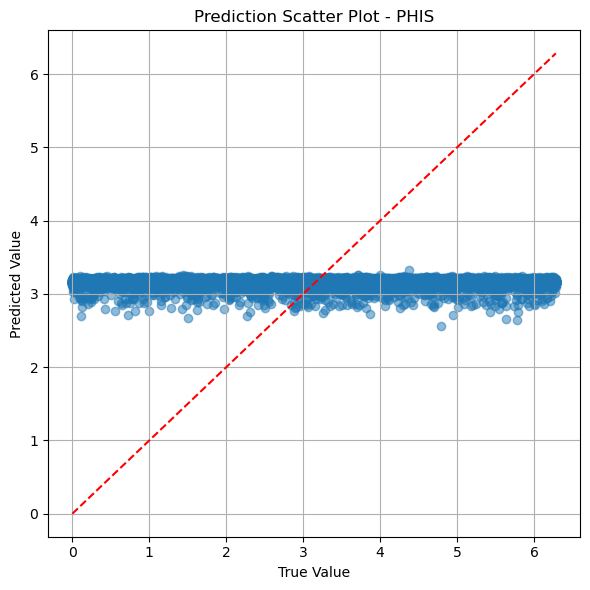

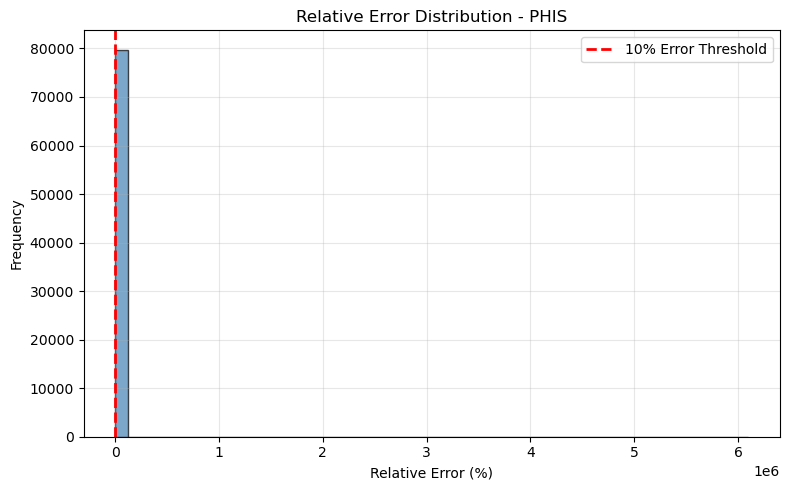

/tmp/ipykernel_36977/1658061326.py:107: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


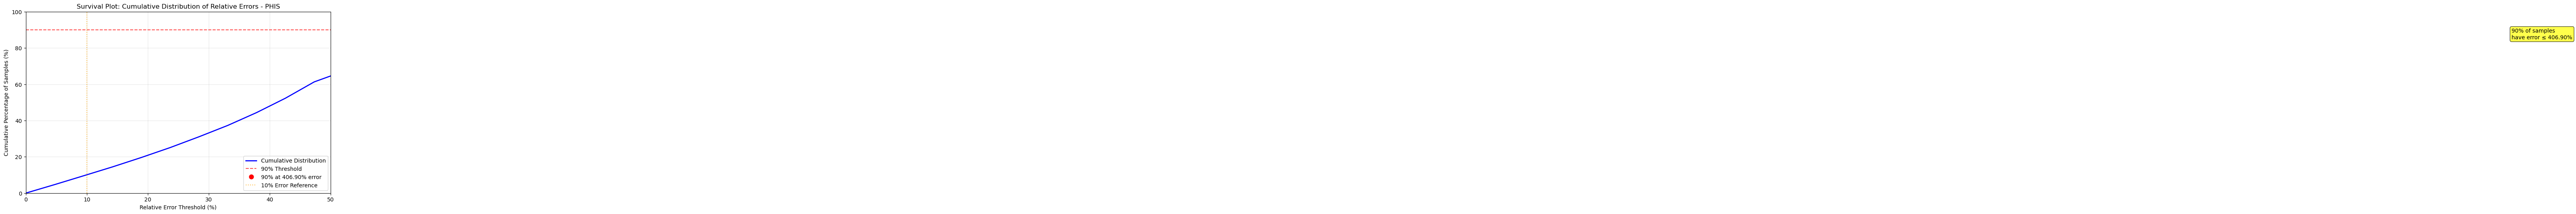


=== Survival Plot Statistics ===
90% of samples have relative error ≤ 406.90%
95% of samples have relative error ≤ 907.96%
99% of samples have relative error ≤ 4726.67%

=== Plots Saved ===
Parameter: PHIS
Save directory: evaluation_plots
Files saved:
  - phis_scatter_plot.png
  - phis_error_histogram.png
  - phis_survival_plot.png


In [51]:
evaluate_mc_model(model, test_loader, label_scaler, device, label_idx=label_idx)